# Download Data

Download all data provided by the organizers.
There are multiple data repositories, according to a nomenclature defined here https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge.



In [7]:
import bs4
import multiprocessing
import os
import pathlib
import random
import requests
import urllib

from tqdm.notebook import tqdm

INDEX_TRAIN_INPUT = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/training-input/0.3.0/netcdf/index.html'
INDEX_TRAIN_OUTPUT = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/training-output-benchmark/index.html'
INDEX_TRAIN_REFERENCE = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/training-output-reference/index.html'

INDEX_TEST_INPUT = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/test-input/0.3.0/netcdf'
INDEX_TEST_OUTPUT = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/test-output-benchmark/index.html'
INDEX_TEST_REFERENCE = 'https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/test-output-reference/index.html'

TARGET_DIR = '***HOME***hdd_scratch/s2s'

In [2]:
def read_index(index_url):
    html = requests.get(index_url).text
    soup = bs4.BeautifulSoup(html, 'html.parser')
    
    table = soup.find_all('tbody')[0]
    links = table.find_all('a')
    dataset_files = [a_tag.attrs['href'] for a_tag in links]
    
    return dataset_files

In [3]:
def download_one_dataset_file(file_url):
    """Inspired by https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests."""
    url_path = urllib.parse.urlparse(file_url).path
    download_path = pathlib.Path(TARGET_DIR) / pathlib.Path(url_path[23:])
    download_path.parent.mkdir(parents=True, exist_ok=True)
    
    with requests.get(file_url, stream=True) as stream:
        if os.path.isfile(download_path):
            """Ignore file if it already exists and file size is ok."""
            stream_len = int(stream.headers['Content-length'])
            local_len = os.path.getsize(download_path)

            if stream_len == local_len:               
                return download_path
        
        
        with open(download_path, 'wb') as f:
            for chunk in stream.iter_content(chunk_size=8192):
                f.write(chunk)
                
    return download_path

In [4]:
dataset_files = []
for index in [INDEX_TRAIN_OUTPUT, INDEX_TRAIN_INPUT, INDEX_TRAIN_REFERENCE, INDEX_TEST_REFERENCE, INDEX_TEST_INPUT, INDEX_TEST_OUTPUT]:
    dataset_files.extend(read_index(index))

In [26]:
local_file = download_one_dataset_file(dataset_files[0])

## Test local file

In [27]:
import xarray as xr

In [32]:
d = xr.open_dataset(local_file)

In [33]:
d

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 1079, latitude: 121, lead_time: 1, longitude: 240)
Coordinates:
  * category       (category) object 'below normal' 'near normal' 'above normal'
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31
  * lead_time      (lead_time) timedelta64[ns] 14 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] ...
Data variables:
    t2m            (category, forecast_time, lead_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...

In [34]:
d.lead_time

<xarray.DataArray 'lead_time' (lead_time: 1)>
array([1209600000000000], dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 14 days

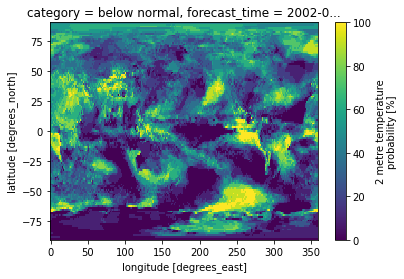

In [36]:
d.t2m.isel(lead_time=0, forecast_time=2, category=0).plot()

## Batch Download

In [ ]:
random.shuffle(dataset_files)

with multiprocessing.Pool(processes=16) as pool:
    for _ in tqdm(pool.imap(download_one_dataset_file, dataset_files), total=len(dataset_files)):
        pass        

  0%|          | 0/6333 [00:00<?, ?it/s]